In [404]:
import bayesflow.diagnostics as diag
from bayesflow.amortizers import AmortizedPosterior
from bayesflow.networks import (InvertibleNetwork, SequenceNetwork, 
                                SetTransformer, DeepSet)
from bayesflow.summary_networks import HierarchicalNetwork
from bayesflow.simulation import GenerativeModel, Prior, Simulator
from bayesflow.trainers import Trainer, SimulationDataset

import tensorflow as tf

import numpy as np
import pickle
from src.SlovotvirModelM import run_model_parallel
import matplotlib.pyplot as plt
from matplotlib import lines
import seaborn as sns

import arviz as az
from tabulate import tabulate
from sklearn.decomposition import PCA
import umap


In [405]:
num_params = 3
epochs = 300
batch_size = 32
learning_rate = 0.001

train_size = 40000
test_size = 4000
valid_size = 4000

RNG = np.random.default_rng(2023)

### 0. Functions and other supplements

In [406]:
# NB: PRIOR MEANS AND STD SHOULD BE THE SAME ACROSS THE BOARD

def configure_input(forward_dict):
    """Function to configure the simulated quantities (i.e., simulator outputs)
    into a neural network-friendly (BayesFlow) format.
    """

    # Prepare placeholder dict
    out_dict = {}

    # Convert data to logscale
    logdata = np.log1p(forward_dict["sim_data"]).astype(np.float32)

    # Extract prior draws and z-standardize with previously computed means
    params = forward_dict["prior_draws"].astype(np.float32)
    # compute prior means and stds
    # prior_means = np.mean(params, axis=0)
    # prior_stds = np.std(params, axis=0)
    # z-standardize
    params = (params - prior_means_2) / prior_stds_2

    # Add to keys
    out_dict["summary_conditions"] = logdata
    out_dict["parameters"] = params

    out_dict["summary_conditions"] = np.expand_dims(out_dict["summary_conditions"], axis=2)

    return out_dict

In [407]:
# def binning(likes, bins=100):
#     likes = likes[:len(likes) - len(likes) % bins]
#     likes = likes.reshape(-1, bins).sum(axis=1)
#     return likes

def binning(likes):
    # Determine the number of bins based on the length of the likes array
    num_bins = int(np.ceil(np.log2(len(likes))))
    
    # Define bin edges at powers of 2 based on the indexes of likes
    bin_edges = 2 ** np.arange(num_bins + 1)
    
    # Assign values to bins
    bin_indices = np.digitize(np.arange(len(likes)), bin_edges)
    
    # Calculate the sum of values in each bin
    bin_sums = np.bincount(bin_indices, weights=likes, minlength=num_bins + 1)
    
    return bin_sums

In [464]:
def plot_posterior(post_samples_, param_names, true_values):
    num_params = len(param_names)
    fig, axs = plt.subplots(1, num_params, figsize=(10, 3.2))

    for i, param_name in enumerate(param_names):
        # Plot posterior density
        sns.kdeplot(post_samples_[:, i], ax=axs[i], color='blue')

        # Get KDE curve for each subplot
        x_values, y_values = sns.kdeplot(post_samples_[:, i], ax=axs[i], color='blue').lines[0].get_data()

        # Fill between specified points for KDE plot
        post_hdi = az.hdi(post_samples_[:, i], hdi_prob=0.95)
        axs[i].fill_between(x_values, y_values, where=(x_values >= post_hdi[0]) & (x_values <= post_hdi[1]), color='blue', alpha=0.3)

        # Plot prior density (assuming uniform for first two parameters and lognormal for the third)
        if i < 2:
            sns.kdeplot(np.random.uniform(0, 10, 10000), ax=axs[i], color='black', linestyle='--')
        else:
            sns.kdeplot(np.random.lognormal(0, sigma=0.5, size=10000), ax=axs[i], color='black', linestyle='--')

        # Plot true values
        axs[i].axvline(true_values[i], color='red', linestyle='--')

        # Remove y-axis labels
        axs[i].set_ylabel('Density')

        # Set titles
        axs[i].set_title(param_name)

    # Add legend below the subplots
    plt.legend(['prior', 'posterior'],
               bbox_to_anchor=(-0.7, -0.2),
               loc='lower center', ncol=num_params,
               frameon=False)

    # Save to pdf
    # plt.savefig('figures/posterior.pdf', bbox_inches='tight', pad_inches=0)

    # Show the plot
    plt.show()


In [408]:
fake_dist = run_model_parallel([10], [1], [1.3], 1)
fake_dist_bins = binning(fake_dist[0])

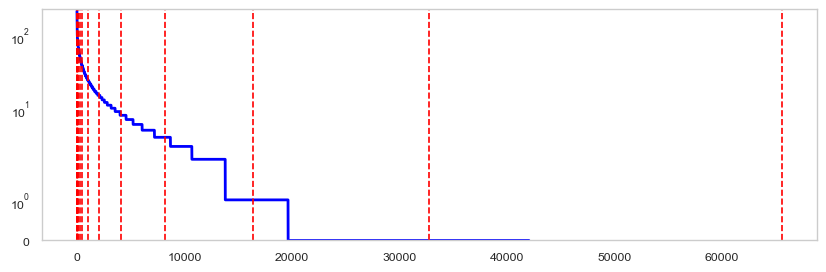

In [411]:
# plot fake dist
plt.figure(figsize=(10, 3))
plt.plot(fake_dist[0], color='blue', linewidth=2)
plt.grid(False)
# add vertical lines at powers of 2
for i in range(1, 17):
    plt.axvline(2 ** i, color="red", linestyle="--", alpha=1)
    # add text from fake_dist_bins turn 90 degrees
    # plt.text(2 ** i - 1, 10^4, str(fake_dist_bins[i-1]), rotation=90)
# plt.xscale("log")
plt.yscale("symlog", base=10)
plt.ylim(0, None)
# plt.xscale("log")
plt.show()

## Inference of all 3 parameters

### 1. Generating training and testing data

In [5]:
# training_params = (np.random.uniform(0, 10, train_size), np.random.uniform(0, 10, train_size), np.random.lognormal(0, 0.5, train_size))
# testing_params = (np.random.uniform(0, 10, test_size), np.random.uniform(0, 10, test_size), np.random.lognormal(0, 0.5, test_size))
# validation_params = (np.random.uniform(0, 10, valid_size), np.random.uniform(0, 10, valid_size), np.random.lognormal(0, 0.5, valid_size))

In [6]:
# prior_means = np.mean(training_params, axis=1)
# prior_stds = np.std(training_params, axis=1)

In [7]:
# training_data = run_model_parallel(training_params[0], training_params[1], training_params[2], train_size)

In [8]:
# testing_data = run_model_parallel(testing_params[0], testing_params[1], testing_params[2], test_size)

In [9]:
# validation_data = run_model_parallel(validation_params[0], validation_params[1], validation_params[2], valid_size)

In [10]:
# training_params = np.vstack(training_params)
# testing_params = np.vstack(testing_params)
# validation_params = np.vstack(validation_params)

In [11]:
# train_data = {}
# train_data["prior_non_batchable_context"] = None
# train_data["prior_batchable_context"] = None
# train_data["prior_draws"] = training_params.reshape(num_params, train_size).T
# train_data["sim_non_batchable_context"] = None
# train_data["sim_batchable_context"] = None
# train_data["sim_data"] = np.array(training_data, dtype = float)


# test_data = {}
# test_data["prior_non_batchable_context"] = None
# test_data["prior_batchable_context"] = None
# test_data["prior_draws"] = testing_params.reshape(num_params, test_size).T
# test_data["sim_non_batchable_context"] = None
# test_data["sim_batchable_context"] = None
# test_data["sim_data"] = np.array(testing_data, dtype = float)

# valid_data = {}
# valid_data["prior_non_batchable_context"] = None
# valid_data["prior_batchable_context"] = None
# valid_data["prior_draws"] = validation_params.reshape(num_params, valid_size).T
# valid_data["sim_non_batchable_context"] = None
# valid_data["sim_batchable_context"] = None
# valid_data["sim_data"] = np.array(validation_data, dtype = float)

In [12]:
# pickle.dump(train_data, open("data/train_data_1205.pkl", "wb"))
# pickle.dump(test_data, open("data/test_data_1205.pkl", "wb"))
# pickle.dump(valid_data, open("data/valid_data_1205.pkl", "wb"))
# load data
train_data = pickle.load(open("data/train_data_1105.pkl", "rb"))
test_data = pickle.load(open("data/test_data_1105.pkl", "rb"))
valid_data = pickle.load(open("data/valid_data_1105.pkl", "rb"))

In [13]:
train_data_ = pickle.load(open("data/train_data_1205.pkl", "rb"))
test_data_ = pickle.load(open("data/test_data_1205.pkl", "rb"))
valid_data_ = pickle.load(open("data/valid_data_1205.pkl", "rb"))

In [14]:
# train_data["sim_data"].shape
train_data_["sim_data"] = np.array(list(map(binning, train_data_["sim_data"])))
test_data_["sim_data"] = np.array(list(map(binning, test_data_["sim_data"])))
valid_data_["sim_data"] = np.array(list(map(binning, valid_data_["sim_data"])))

In [15]:
# combine sim_data and prior_draws
train_data["sim_data"] = np.concatenate((train_data["sim_data"], train_data_["sim_data"]))
train_data["prior_draws"] = np.concatenate((train_data["prior_draws"], train_data_["prior_draws"]))
test_data["sim_data"] = np.concatenate((test_data["sim_data"], test_data_["sim_data"]))
test_data["prior_draws"] = np.concatenate((test_data["prior_draws"], test_data_["prior_draws"]))
valid_data["sim_data"] = np.concatenate((valid_data["sim_data"], valid_data_["sim_data"]))
valid_data["prior_draws"] = np.concatenate((valid_data["prior_draws"], valid_data_["prior_draws"]))

In [16]:
# # apply binning to each entry in sim_data using map
# train_data["sim_data"] = np.array(list(map(binning, train_data["sim_data"])))
# test_data["sim_data"] = np.array(list(map(binning, test_data["sim_data"])))
# valid_data["sim_data"] = np.array(list(map(binning, valid_data["sim_data"])))

In [17]:
prior_means = np.mean(train_data["prior_draws"], axis=0)
prior_stds = np.std(train_data["prior_draws"], axis=0)

In [18]:
train_data['sim_data'].shape

(80000, 17)

### 2. Training the model

In [19]:
summary_net = DeepSet(summary_dim=4)
inference_net = InvertibleNetwork(num_params=num_params, num_coupling_layers=4)
amortizer = AmortizedPosterior(inference_net, summary_net, name="slovotvir_amortizer")
trainer = Trainer(amortizer=amortizer, 
                  configurator=configure_input, 
                  memory=True)

In [23]:
schedule = tf.keras.optimizers.schedules.CosineDecay(learning_rate, epochs * SimulationDataset(train_data, batch_size).num_batches, 
                                                     name = "lr_decay")
optimizer = tf.keras.optimizers.legacy.Adam(schedule, global_clipnorm = 1)

In [64]:
#run training and save
history = trainer.train_offline(simulations_dict = train_data, epochs = epochs, 
                                batch_size = batch_size, optimizer = optimizer, 
                                validation_sims = test_data,
                                early_stopping=True, patience=20)
trainer._save_trainer("model")

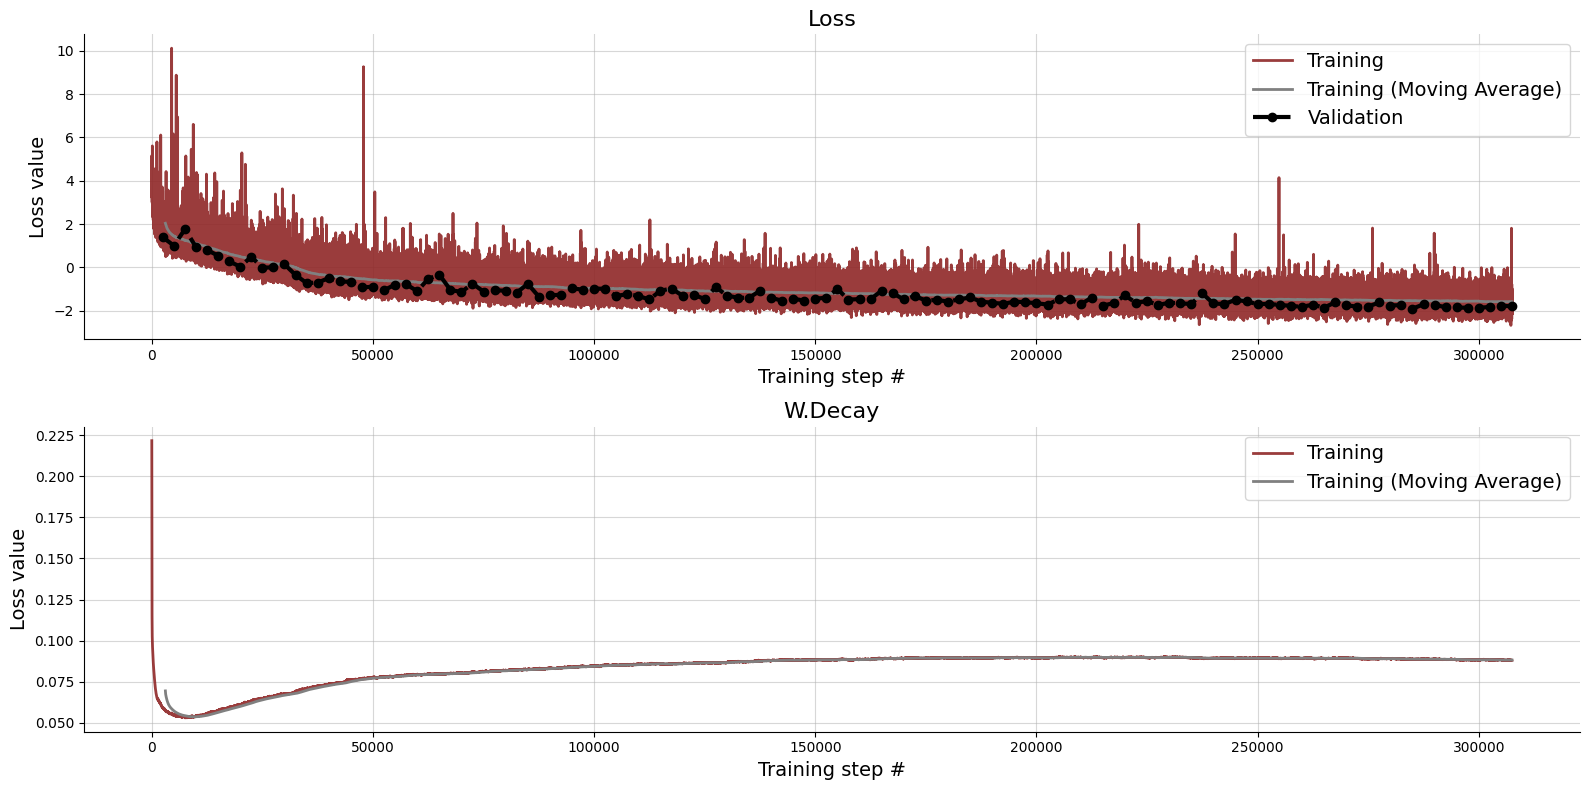

In [26]:
f = diag.plot_losses(history["train_losses"], history["val_losses"], moving_average=True)

### 3. Model analysis

In [270]:
# Generate some validation data
validation_sims = trainer.configurator(valid_data) 
prior_samples = validation_sims["parameters"] * prior_stds + prior_means
# Generate posterior draws for all simulations
post_samples = amortizer.sample(validation_sims, n_samples=100)
post_samples = post_samples * prior_stds + prior_means

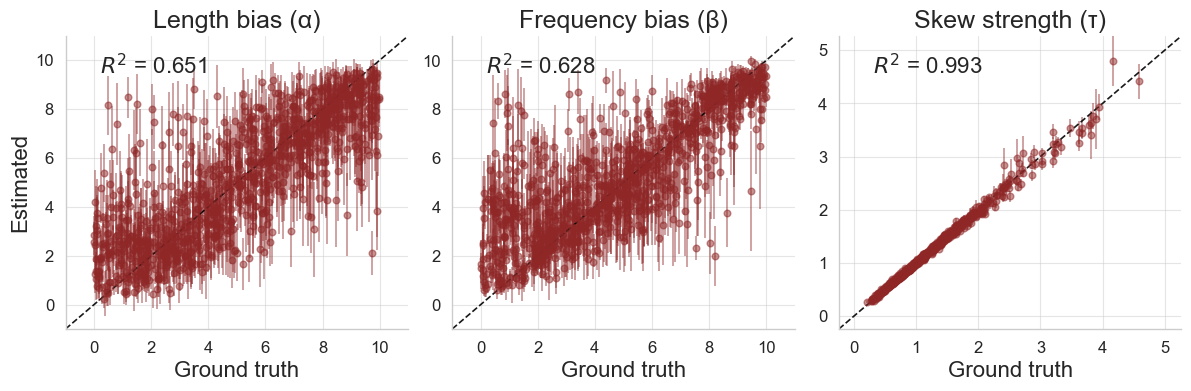

In [271]:
fig = diag.plot_recovery(post_samples[0:1000], prior_samples[0:1000], add_corr=False,
                         param_names=['Length bias (α)', 'Frequency bias (β)', 'Skew strength (τ)'],
                         )
# point_agg=np.mean, uncertainty_agg=np.std

In [272]:
post_samples.shape

(8000, 100, 3)

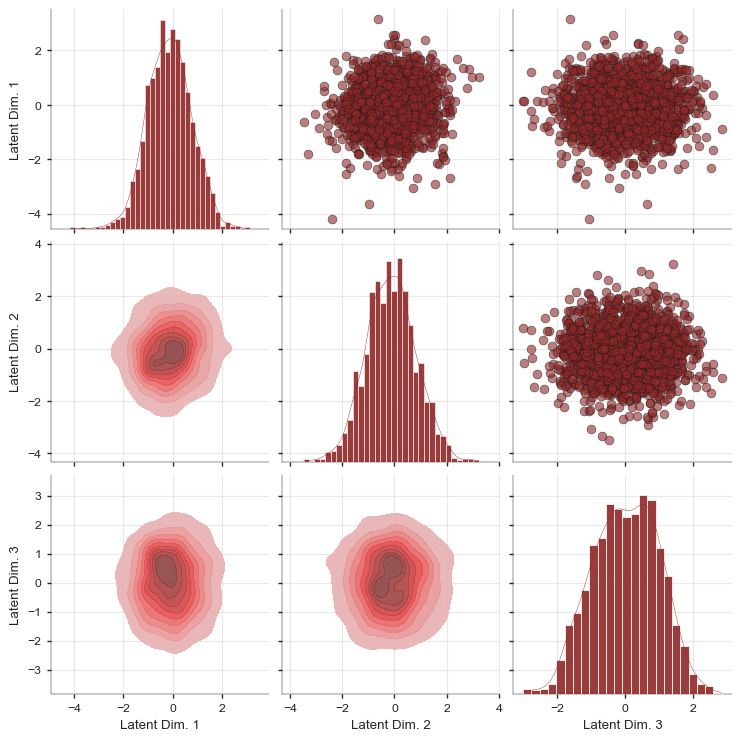

In [197]:
f = trainer.diagnose_latent2d()

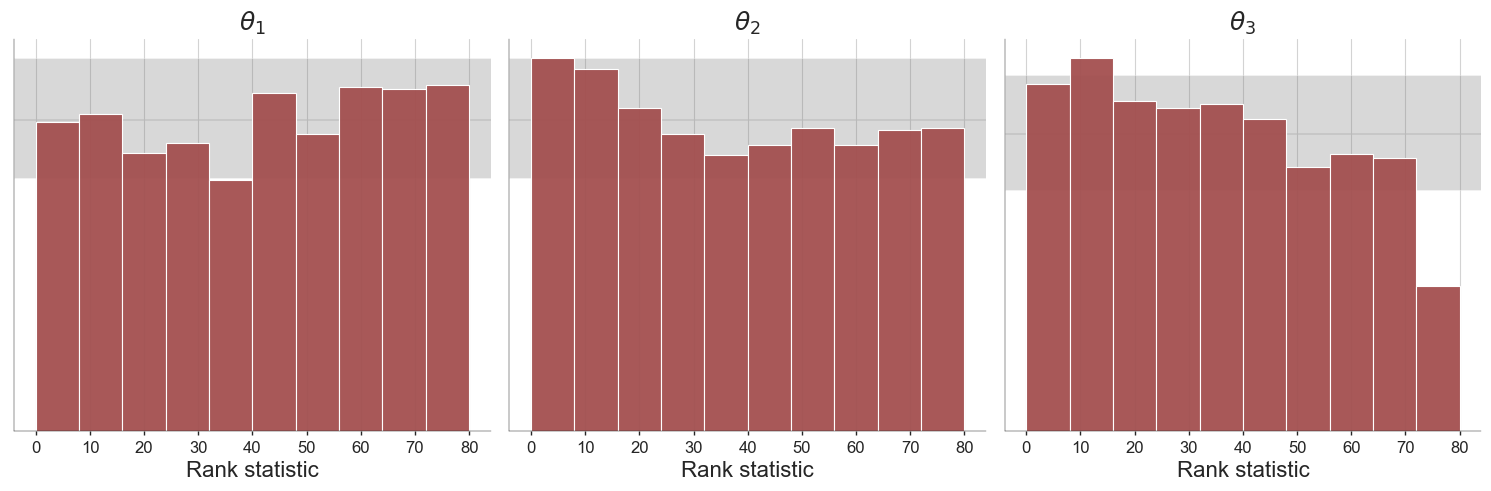

In [198]:
f = trainer.diagnose_sbc_histograms()

### 4. Posterior analysis

In [416]:
a = 5
b = 5
tau = 0.8

In [417]:
fake_dist = run_model_parallel([a], [b], [tau], 1)
fake_dist_t = fake_dist.copy()
# apply binning to each entry in sim_data using map
fake_dist = np.array(list(map(binning, fake_dist)))

In [290]:
fake_dist[0].sum()

129974.0

In [291]:
fake_dist[0].shape

(17,)

In [292]:
obs_data = np.log1p(fake_dist[0])[np.newaxis, :, np.newaxis].astype(np.float32)

In [293]:
# Obtain 500 posterior draws given real data
post_samples_ = amortizer.sample({"summary_conditions": obs_data}, 10000)

# Undo standardization to get parameters on their original (unstandardized) scales
post_samples_ = prior_means + post_samples_ * prior_stds

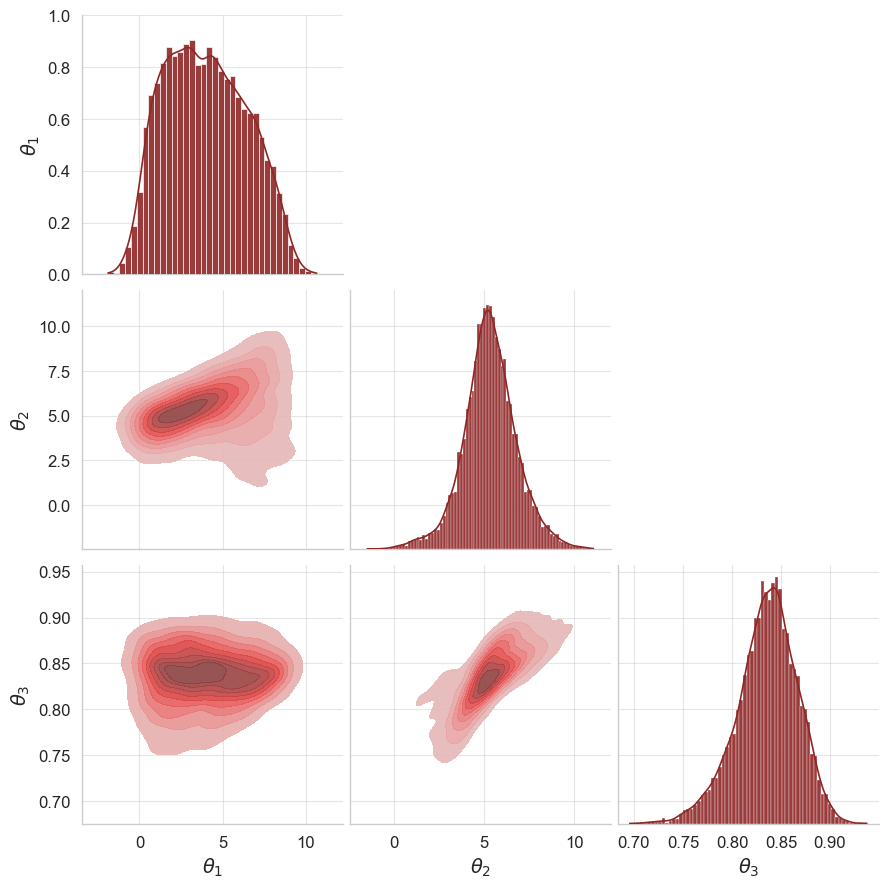

In [294]:
f = diag.plot_posterior_2d(post_samples_)

In [295]:
ps = ['α', 'β', 'τ']
table_data = []
for _ in range(3):
    row = [ps[_], np.mean(post_samples_[:, _]).round(3), az.hdi(post_samples_[:, _], hdi_prob=0.95).round(3)]
    table_data.append(row)

table_headers = ['Parameter', 'Mean', 'HDI']
latex_table = tabulate(table_data, headers=table_headers, tablefmt='latex')
print(latex_table)

\begin{tabular}{lrl}
\hline
 Parameter   &   Mean & HDI             \\
\hline
 α           &  3.997 & [-0.023  8.522] \\
 β           &  5.322 & [2.471 8.658]   \\
 τ           &  0.836 & [0.771 0.893]   \\
\hline
\end{tabular}


In [296]:
fake_dist_ = run_model_parallel([np.mean(post_samples_[:, 0])] * 100, 
                                [np.mean(post_samples_[:, 1])] * 100, 
                                [np.mean(post_samples_[:, 2])] * 100, 100)

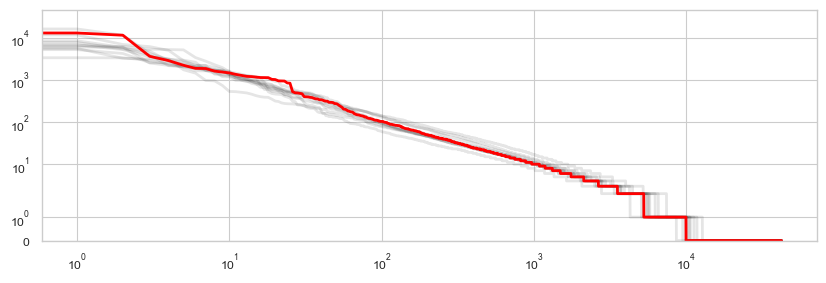

In [297]:
# plot fake dist
plt.figure(figsize=(10, 3))
for _ in range(10):
    plt.plot(fake_dist_[_], color='black', linewidth=2, alpha=0.1)
plt.plot(fake_dist_t[0], color='red', linewidth=2)
plt.xscale("log")
plt.yscale("symlog", base=10)
plt.ylim(0, None)
plt.show()

In [298]:
post_hdi = az.hdi(post_samples_, hdi_prob=0.95)

/var/folders/1c/pphtjl397rnbdcp94xmwzkqr0000gn/T/ipykernel_2534/3047408444.py:1: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  post_hdi = az.hdi(post_samples_, hdi_prob=0.95)


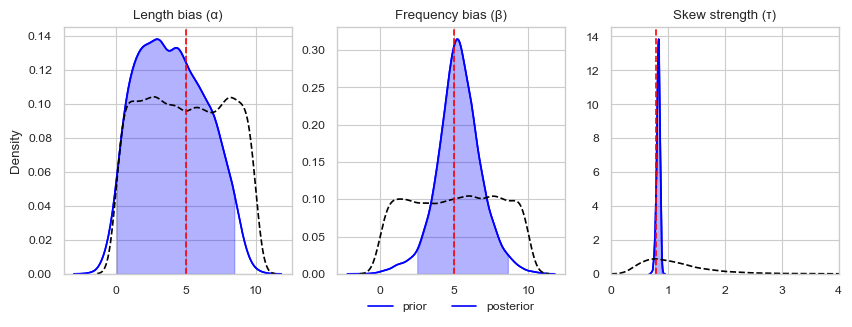

In [299]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3.2))

# Plot posterior density
sns.kdeplot(post_samples_[:, 0], ax=axs[0], color='blue')
sns.kdeplot(post_samples_[:, 1], ax=axs[1], color='blue')
sns.kdeplot(post_samples_[:, 2], ax=axs[2], color='blue')

# Get KDE curve for each subplot
x_values_0, y_values_0 = sns.kdeplot(post_samples_[:, 0], ax=axs[0], color='blue').lines[0].get_data()
x_values_1, y_values_1 = sns.kdeplot(post_samples_[:, 1], ax=axs[1], color='blue').lines[0].get_data()
x_values_2, y_values_2 = sns.kdeplot(post_samples_[:, 2], ax=axs[2], color='blue').lines[0].get_data()

# Fill between specified points for each KDE plot
axs[0].fill_between(x_values_0, y_values_0, where=(x_values_0 >= post_hdi[0, 0]) & (x_values_0 <= post_hdi[0, 1]), color='blue', alpha=0.3)
axs[1].fill_between(x_values_1, y_values_1, where=(x_values_1 >= post_hdi[1, 0]) & (x_values_1 <= post_hdi[1, 1]), color='blue', alpha=0.3)
axs[2].fill_between(x_values_2, y_values_2, where=(x_values_2 >= post_hdi[2, 0]) & (x_values_2 <= post_hdi[2, 1]), color='blue', alpha=0.3)

# Plot prior density
sns.kdeplot(np.random.uniform(0, 10, 10000), 
            ax=axs[0], color='black', linestyle='--')
sns.kdeplot(np.random.uniform(0, 10, 10000), 
            ax=axs[1], color='black', linestyle='--')
sns.kdeplot(np.random.lognormal(0, sigma=0.5, size=10000), 
            ax=axs[2], color='black', linestyle='--')

# plot true values
axs[0].axvline(a, color='red', linestyle='--')
axs[1].axvline(b, color='red', linestyle='--')
axs[2].axvline(tau, color='red', linestyle='--')

# remove y axis labels
axs[0].set_ylabel('Density')
axs[2].set_ylabel('')
axs[1].set_ylabel('')

# Set xlim for [2] to 0, 4
axs[2].set_xlim(0, 4)

# Set titles
titles_ = ['Length bias (α)', 'Frequency bias (β)', 'Skew strength (τ)']
for i, ax in enumerate(axs):
    ax.set_title(titles_[i])

# Add legend below the subplots
plt.legend(['prior', 'posterior'], 
           bbox_to_anchor=(-0.7, -0.2),
           loc='lower center', ncol=3,
           frameon=False)

# # Save to pdf
# plt.savefig('figures/posterior.pdf', bbox_inches='tight', pad_inches=0)

# Show the plot
plt.show()

In [300]:
# Perform PCA
pca = PCA(n_components=2, whiten=True)
pca_result = pca.fit_transform(train_data['sim_data'])

true_hist = obs_data.reshape(1, -1)
pca_true = pca.transform(true_hist)

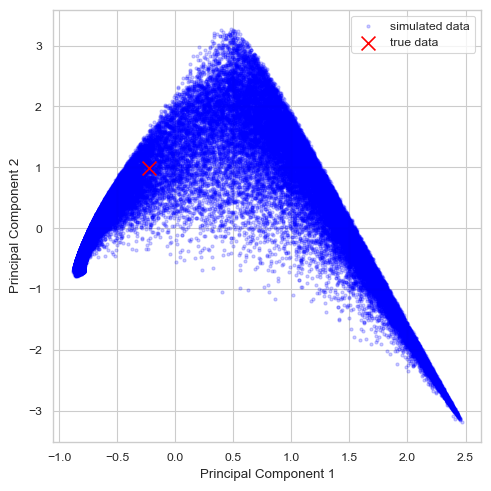

In [301]:
# Plot PCA
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(pca_result[:, 0], pca_result[:, 1], 
            s=5, color = 'blue', 
            alpha=0.2, label='simulated data')
plt.scatter(pca_true[:, 0], pca_true[:, 1],
             s=100, color='red', marker='x', 
             label='true data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.tight_layout()
plt.savefig('figures/pca.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

## Inference of alpha and beta knowing tau

### 1. Data generation

In [355]:
train_size = 10000
test_size = 1000
valid_size = 1000

num_params = 2

In [356]:
np.mean(post_samples_[:, 2])

0.8355922329001715

In [357]:
training_params_2 = (np.random.uniform(0, 10, train_size), 
                   np.random.uniform(0, 10, train_size), 
                  [np.mean(post_samples_[:, 2])] * train_size)
testing_params_2 = (np.random.uniform(0, 10, test_size), 
                  np.random.uniform(0, 10, test_size), 
                 [np.mean(post_samples_[:, 2])] * test_size)
validation_params_2 = (np.random.uniform(0, 10, valid_size), 
                     np.random.uniform(0, 10, valid_size),
                    [np.mean(post_samples_[:, 2])] * valid_size)

In [358]:
training_data_2 = run_model_parallel(training_params_2[0], training_params_2[1], training_params_2[2], train_size)

In [359]:
testing_data_2 = run_model_parallel(testing_params_2[0], testing_params_2[1], testing_params_2[2], test_size)

In [360]:
validation_data_2 = run_model_parallel(validation_params_2[0], validation_params_2[1], validation_params_2[2], valid_size)

In [361]:
training_params_2 = np.vstack(training_params_2)
testing_params_2 = np.vstack(testing_params_2)
validation_params_2 = np.vstack(validation_params_2)

In [362]:
# remove last array from params
training_params_2 = training_params_2[:-1]
testing_params_2 = testing_params_2[:-1]
validation_params_2 = validation_params_2[:-1]

In [363]:
train_data_2 = {}
train_data_2["prior_non_batchable_context"] = None
train_data_2["prior_batchable_context"] = None
train_data_2["prior_draws"] = training_params_2.reshape(num_params, train_size).T
train_data_2["sim_non_batchable_context"] = None
train_data_2["sim_batchable_context"] = None
train_data_2["sim_data"] = np.array(training_data_2, dtype = float)


test_data_2 = {}
test_data_2["prior_non_batchable_context"] = None
test_data_2["prior_batchable_context"] = None
test_data_2["prior_draws"] = testing_params_2.reshape(num_params, test_size).T
test_data_2["sim_non_batchable_context"] = None
test_data_2["sim_batchable_context"] = None
test_data_2["sim_data"] = np.array(testing_data_2, dtype = float)

valid_data_2 = {}
valid_data_2["prior_non_batchable_context"] = None
valid_data_2["prior_batchable_context"] = None
valid_data_2["prior_draws"] = validation_params_2.reshape(num_params, valid_size).T
valid_data_2["sim_non_batchable_context"] = None
valid_data_2["sim_batchable_context"] = None
valid_data_2["sim_data"] = np.array(validation_data_2, dtype = float)

In [364]:
# train_data["sim_data"].shape
train_data_2["sim_data"] = np.array(list(map(binning, train_data_2["sim_data"])))
test_data_2["sim_data"] = np.array(list(map(binning, test_data_2["sim_data"])))
valid_data_2["sim_data"] = np.array(list(map(binning, valid_data_2["sim_data"])))

In [376]:
prior_means_2 = np.mean(train_data_2["prior_draws"], axis=0)
prior_stds_2 = np.std(train_data_2["prior_draws"], axis=0)

### 2. Model training

In [377]:
summary_net = DeepSet(summary_dim=4)
inference_net = InvertibleNetwork(num_params=num_params, num_coupling_layers=4)
amortizer = AmortizedPosterior(inference_net, summary_net, name="slovotvir_amortizer")
trainer = Trainer(amortizer=amortizer, 
                  configurator=configure_input, 
                  memory=True)

INFO:root:Trainer initialization: No generative model provided. Only offline learning mode is available!


In [378]:
schedule = tf.keras.optimizers.schedules.CosineDecay(learning_rate, epochs * SimulationDataset(train_data, batch_size).num_batches, 
                                                     name = "lr_decay")
optimizer = tf.keras.optimizers.legacy.Adam(schedule, global_clipnorm = 1)

In [385]:
#run training and save
history = trainer.train_offline(simulations_dict = train_data_2, epochs = 100, 
                                batch_size = batch_size, optimizer = optimizer, 
                                validation_sims = test_data_2,
                                early_stopping=True, patience=20)
trainer._save_trainer("model_tau")

Training epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1, Loss: 1.202


Training epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 2, Loss: 1.258


Training epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 3, Loss: 0.867


Training epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 4, Loss: 0.902


Training epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 5, Loss: 0.734


Training epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 6, Loss: 1.067


Training epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 7, Loss: 0.755


Training epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 8, Loss: 0.949


Training epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 9, Loss: 1.055


Training epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 10, Loss: 1.222


Training epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 11, Loss: 1.083


Training epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 12, Loss: 0.631


Training epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 13, Loss: 0.930


Training epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 14, Loss: 0.613


Training epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 15, Loss: 0.650


Training epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 16, Loss: 0.635


Training epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 17, Loss: 0.582


Training epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 18, Loss: 1.190


Training epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 19, Loss: 1.237


Training epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 20, Loss: 0.572


Training epoch 21:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 21, Loss: 0.599


Training epoch 22:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 22, Loss: 0.455


Training epoch 23:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 23, Loss: 0.467


Training epoch 24:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 24, Loss: 0.825


Training epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 25, Loss: 0.688


Training epoch 26:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 26, Loss: 0.764


Training epoch 27:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 27, Loss: 0.644


Training epoch 28:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 28, Loss: 0.532


Training epoch 29:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 29, Loss: 0.703


Training epoch 30:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 30, Loss: 0.563


Training epoch 31:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 31, Loss: 1.396


Training epoch 32:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 32, Loss: 0.604


Training epoch 33:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 33, Loss: 0.502


Training epoch 34:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 34, Loss: 0.436


Training epoch 35:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 35, Loss: 1.096


Training epoch 36:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 36, Loss: 0.460


Training epoch 37:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 37, Loss: 0.530


Training epoch 38:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 38, Loss: 0.517


Training epoch 39:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 39, Loss: 0.551


Training epoch 40:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 40, Loss: 0.479


Training epoch 41:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 41, Loss: 0.723


Training epoch 42:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 42, Loss: 0.457


Training epoch 43:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 43, Loss: 0.482


Training epoch 44:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 44, Loss: 0.558


Training epoch 45:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 45, Loss: 0.575


Training epoch 46:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 46, Loss: 0.600


Training epoch 47:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 47, Loss: 0.758


Training epoch 48:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 48, Loss: 0.531


Training epoch 49:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 49, Loss: 0.685


Training epoch 50:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 50, Loss: 0.508


Training epoch 51:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 51, Loss: 0.436


Training epoch 52:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 52, Loss: 1.307


Training epoch 53:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 53, Loss: 0.447


Training epoch 54:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 54, Loss: 0.339


Training epoch 55:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 55, Loss: 0.305


Training epoch 56:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 56, Loss: 0.418


Training epoch 57:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 57, Loss: 0.662


Training epoch 58:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 58, Loss: 0.835


Training epoch 59:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 59, Loss: 0.480


Training epoch 60:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 60, Loss: 0.548


Training epoch 61:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 61, Loss: 0.906


Training epoch 62:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 62, Loss: 0.320


Training epoch 63:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 63, Loss: 0.533


Training epoch 64:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 64, Loss: 0.323


Training epoch 65:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 65, Loss: 0.753


Training epoch 66:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 66, Loss: 0.323


Training epoch 67:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 67, Loss: 0.422


Training epoch 68:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 68, Loss: 0.342


Training epoch 69:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 69, Loss: 0.326


Training epoch 70:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 70, Loss: 0.544


Training epoch 71:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 71, Loss: 0.452


Training epoch 72:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 72, Loss: 0.297


Training epoch 73:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 73, Loss: 0.245


Training epoch 74:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 74, Loss: 0.372


Training epoch 75:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 75, Loss: 0.508


Training epoch 76:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 76, Loss: 0.250


Training epoch 77:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 77, Loss: 0.714


Training epoch 78:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 78, Loss: 0.644


Training epoch 79:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 79, Loss: 0.474


Training epoch 80:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 80, Loss: 0.567


Training epoch 81:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 81, Loss: 0.217


Training epoch 82:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 82, Loss: 0.371


Training epoch 83:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 83, Loss: 0.278


Training epoch 84:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 84, Loss: 0.367


Training epoch 85:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 85, Loss: 0.560


Training epoch 86:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 86, Loss: 0.264


Training epoch 87:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 87, Loss: 0.652


Training epoch 88:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 88, Loss: 0.600


Training epoch 89:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 89, Loss: 0.356


Training epoch 90:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 90, Loss: 0.552


Training epoch 91:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 91, Loss: 0.689


Training epoch 92:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 92, Loss: 0.538


Training epoch 93:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 93, Loss: 0.403


Training epoch 94:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 94, Loss: 0.238


Training epoch 95:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 95, Loss: 0.281


Training epoch 96:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 96, Loss: 0.221


Training epoch 97:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 97, Loss: 0.302


Training epoch 98:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 98, Loss: 0.332


Training epoch 99:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 99, Loss: 0.187


Training epoch 100:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 100, Loss: 0.332


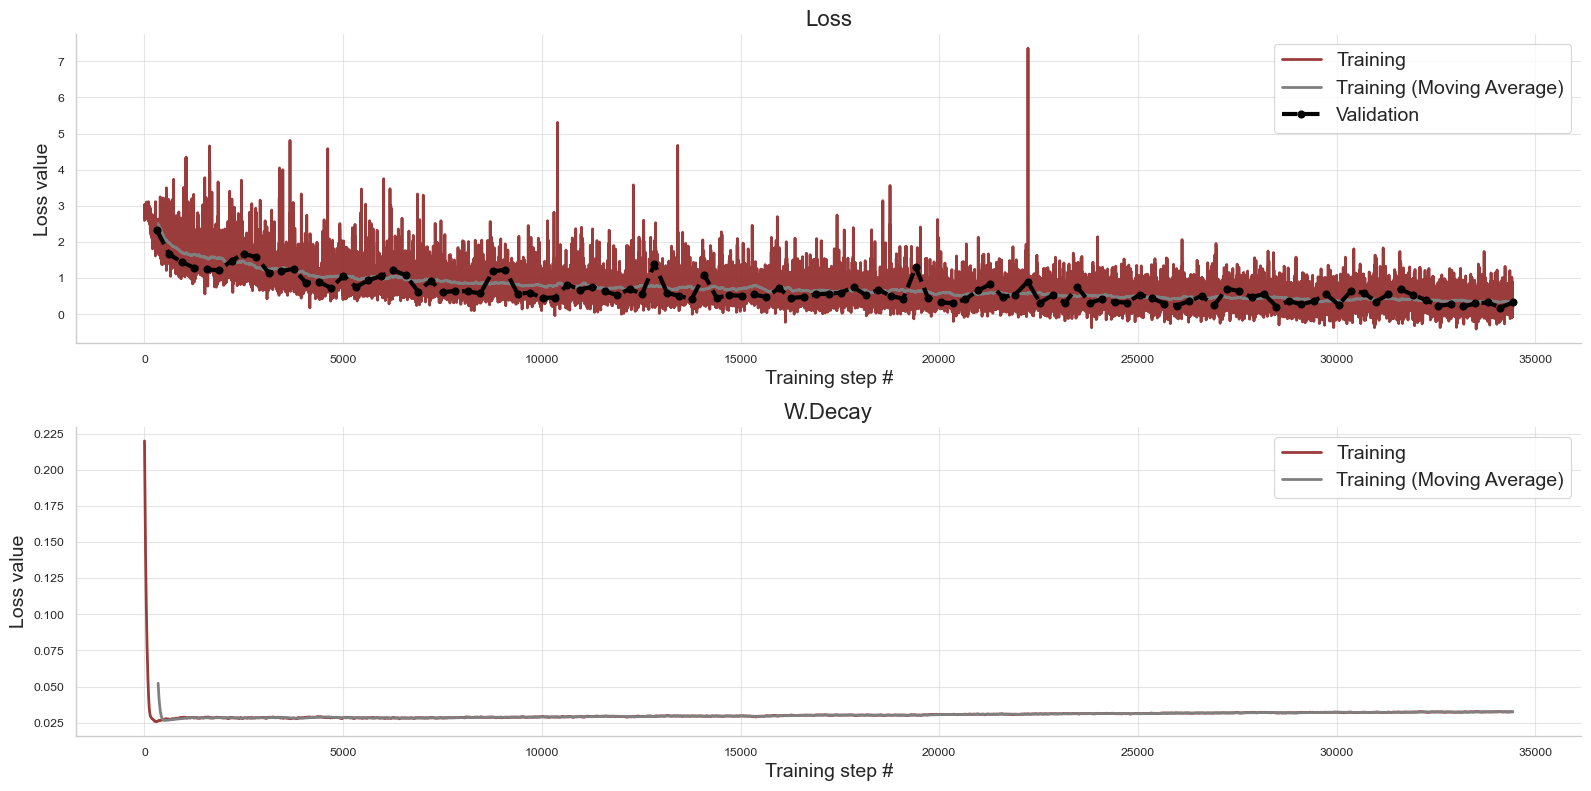

In [386]:
f = diag.plot_losses(history["train_losses"], history["val_losses"], moving_average=True)

In [387]:
# Generate some validation data
validation_sims = trainer.configurator(valid_data_2) 
prior_samples = validation_sims["parameters"] * prior_stds_2 + prior_means_2
# Generate posterior draws for all simulations
post_samples = amortizer.sample(validation_sims, n_samples=100)
post_samples = post_samples * prior_stds_2 + prior_means_2

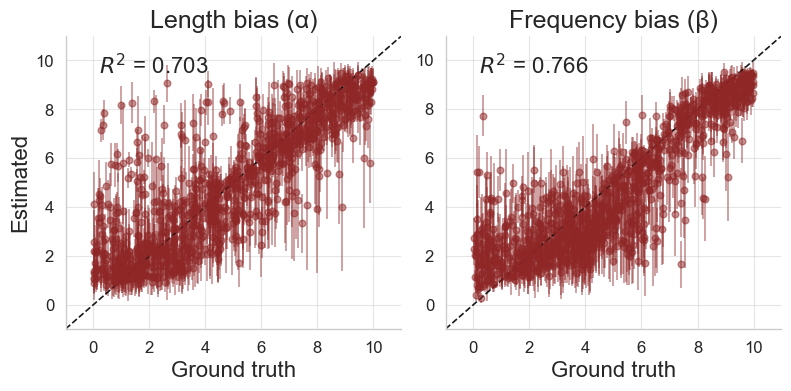

In [389]:
fig = diag.plot_recovery(post_samples[0:1000], prior_samples[0:1000], add_corr=False,
                         param_names=['Length bias (α)', 'Frequency bias (β)'],
                         )
# point_agg=np.mean, uncertainty_agg=np.std

### 4. Posterior analysis

In [466]:
a = 1
b = 10
tau = 0.8355922329001715

In [467]:
fake_dist = run_model_parallel([a], [b], [tau], 1)
fake_dist = np.array(list(map(binning, fake_dist)))

In [468]:
obs_data = np.log1p(fake_dist[0])[np.newaxis, :, np.newaxis].astype(np.float32)

In [469]:
# Obtain 500 posterior draws given real data
post_samples_ = amortizer.sample({"summary_conditions": obs_data}, 10000)

# Undo standardization to get parameters on their original (unstandardized) scales
post_samples_ = prior_means_2 + post_samples_ * prior_stds_2

In [470]:
ps = ['α', 'β']
table_data = []
for _ in range(2):
    row = [ps[_], np.mean(post_samples_[:, _]).round(3), az.hdi(post_samples_[:, _], hdi_prob=0.95).round(3)]
    table_data.append(row)

table_headers = ['Parameter', 'Mean', 'HDI']
latex_table = tabulate(table_data, headers=table_headers, tablefmt='latex')
print(latex_table)

\begin{tabular}{lrl}
\hline
 Parameter   &   Mean & HDI             \\
\hline
 α           &  1.074 & [-0.386  2.826] \\
 β           &  9.377 & [ 8.63 10.15]   \\
\hline
\end{tabular}


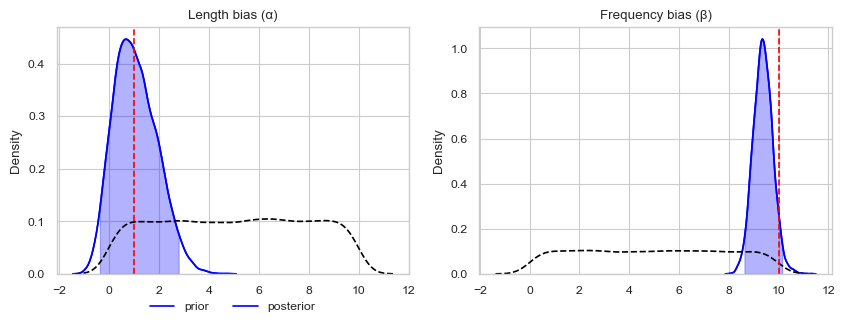

In [471]:
plot_posterior(post_samples_, ['Length bias (α)', 'Frequency bias (β)'], [a, b])